In [1]:
# Data Processing
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import torch

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, classification_report, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

# save model to file
import pickle

In [2]:
data = pd.read_csv("/media/csuser/DATA/ARTEMIS/yale/yale_triage_smote.csv", sep=",")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589260 entries, 0 to 589259
Columns: 208 entries, triage_vital_temp to esi
dtypes: float64(208)
memory usage: 935.1 MB


In [4]:
# Split the data into features (X) and target (y)
X = data.drop(['esi'], axis=1)
y = data['esi']

print(y.head())

# Split the data into training and test sets
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=1)

print(type(X_tr))

X_train = torch.tensor(X_tr.values, dtype=torch.float64)
y_train = torch.tensor(y_tr.values.reshape(-1,1), dtype=torch.long)
X_test = torch.tensor(X_te.values, dtype=torch.float64)
y_test = torch.tensor(y_te.values.reshape(-1,1), dtype=torch.long)

print(y_test.shape)

# convert to one hot vector
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False).fit(y_train)
print(ohe.categories_)

y_train = torch.from_numpy(ohe.transform(y_train))
y_test = torch.from_numpy(ohe.transform(y_test))
y_test.shape

0    4.0
1    2.0
2    3.0
3    3.0
4    4.0
Name: esi, dtype: float64
<class 'pandas.core.frame.DataFrame'>
torch.Size([117852, 1])
[array([1, 2, 3, 4, 5])]


torch.Size([117852, 5])

In [5]:
rf = RandomForestClassifier()
rf.fit(X_train.numpy(), y_train.numpy())

y_pred = rf.predict(X_test.numpy())

In [6]:
# load saved model
# rfs = pickle.load(open('/media/csuser/DATA/ARTEMIS/models/RF_yale_smote.pickle', 'rb'))
# y_pred = rfs.predict(X_test.numpy())

In [7]:
from numpy import argmax

print(y_test.shape)
print(y_pred.shape)
y_test = argmax(a=y_test, axis=1)
y_pred = argmax(a=y_pred, axis=1)
print(y_test)
print(y_pred)

torch.Size([117852, 5])
(117852, 5)
tensor([4, 4, 0,  ..., 1, 4, 1])
[0 4 0 ... 1 3 1]


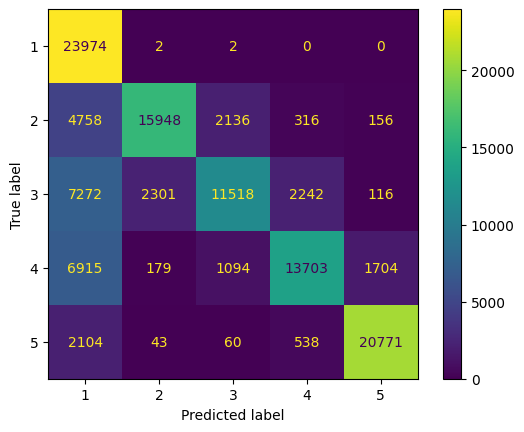

In [8]:
ConfusionMatrixDisplay.from_predictions(y_test+1, y_pred+1)
#plt.savefig('/media/csuser/DATA/ARTEMIS/yale/figs/RF_confusion_yale_smote.png', dpi=300)

In [9]:
cm = confusion_matrix(y_test, y_pred)

# FP = cm.sum(axis=0) - np.diag(cm)  
# FN = cm.sum(axis=1) - np.diag(cm)
# TP = np.diag(cm)
# TN = cm.sum(axis=0) - (FP + FN + TP)

TP = np.zeros(5)
FP = np.zeros(5)
FN = np.zeros(5)

for i in range(5):
    for j in range(len(y_test)):
        if y_test[j] == i and y_pred[j] == i:
            TP[i] += 1
        elif y_test[j] == i and y_pred[j] != i:
            FN[i] += 1
        elif y_test[j] != i and y_pred[j] == i:
            FP[i] += 1
print(TP, FN, FP)
# print(TP1, FN1, FP1)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# # Specificity or true negative rate
# TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# # Negative predictive value
# NPV = TN/(TN+FN)
# # Fall out or false positive rate
# FPR = FP/(FP+TN)
# # False negative rate
# FNR = FN/(TP+FN)
# # False discovery rate
# FDR = FP/(TP+FP)

# Overall accuracy
#ACC = (TP+TN)/(TP+FP+FN+TN)
ACC = np.zeros(5)
class_totals = np.zeros(5)
for i in range(5):
    for j in range(len(y_test)):
        class_totals[y_test[j]] += 1
        if y_test[j] == y_pred[j]:
            ACC[y_test[j]] += 1
ACC /= class_totals

# F1
F1 = 2 * (PPV * TPR) / (PPV + TPR)

# print(TPR, TNR, PPV, NPV, FPR, FDR, ACC)
print(PPV, TPR, F1, ACC)

[23974. 15948. 11518. 13703. 20771.] [4.0000e+00 7.3660e+03 1.1931e+04 9.8920e+03 2.7450e+03] [21049.  2525.  3292.  3096.  1976.]
[0.5324834  0.86331403 0.77771776 0.81570332 0.9131314 ] [0.99983318 0.6840525  0.49119365 0.58075864 0.88327096] [0.69488848 0.76329959 0.60210669 0.6784671  0.89795301] [0.99983318 0.6840525  0.49119365 0.58075864 0.88327096]


In [10]:
print(np.sum(ACC)/5)

0.7278217870252428


In [11]:
acc = accuracy_score(y_test, y_pred)
print('Acc: ', acc)

prec = precision_score(y_test, y_pred, average='weighted')
print('Prec: ', prec)

recall = recall_score(y_test, y_pred, average='weighted')
print('Recall: ', recall)

Acc:  0.7289990835963751
Prec:  0.7793810168400402
Recall:  0.7289990835963751


In [12]:
!pwd

/media/csuser/DATA/ARTEMIS/yale


In [13]:
with open('/media/csuser/DATA/ARTEMIS/models/RF_yale_smote.pickle', 'wb') as f:
    pickle.dump(rf, f)